In [9]:
from pickle import load
from scipy.cluster.hierarchy import ClusterNode
import math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import numpy.linalg as lalg
from cairosvg import svg2png
%matplotlib inline

In [10]:
class TreeNode:
    '''needed because ClusterNode for dendrogram is binary'''
    def __init__(self, idx, dist):
        self.idx = idx
        self.dist = dist
        self.children = []
        
        self.parent = None
        self.length = None
        self.angle = None

In [66]:
def prune(clustroot: ClusterNode, mingap, length_exp=1) -> TreeNode:
    # first build tree with merged branches
    def build(node: ClusterNode):
        if node is None:
            return None
        
        here = TreeNode(node.id, node.dist/clustroot.dist) # normalise
        left = build(node.left)
        right = build(node.right)
        
        # if leaf, just return
        if left is None:
            assert right is None # should be satisfied from dendrogram
            return here
    
        # merge child into self if not leaf and gap is smaller than min
        if len(left.children) != 0 and here.dist-left.dist < mingap:
            here.children.extend(left.children)
        else:
            here.children.append(left)
        # and same for right
        if len(right.children) != 0 and here.dist-right.dist < mingap:
            here.children.extend(right.children)
        else:
            here.children.append(right)
        return here
    
    root = build(clustroot)
    
    # count number of leaves and set parent pointers
    nleaves = 0
    nbranches = 0
    def count(node: TreeNode):
        if node is None:
            return
        if len(node.children) == 0:
            nonlocal nleaves
            nleaves += 1
        else:
            nonlocal nbranches
            nbranches += 1
            for child in node.children:
                child.parent = node
                count(child)
                
    count(root)
    
    # place each node at the midangle of its children
    n = nleaves + nbranches
    leafcounter = 0
    branchcounter = 0
    def place(node: TreeNode):
        assert node is not None
        if len(node.children) == 0:
            nonlocal leafcounter
            node.angle = (leafcounter / nleaves) * 2 * math.pi
            node.length = 1
            leafcounter += 1
            return 1
        else:
            total_leaves = sum(place(child) for child in node.children)
            node.length = (1 - (total_leaves / nleaves)) ** length_exp # exponent makes layout more uniform
            node.angle = (node.children[0].angle + node.children[-1].angle) / 2
            
            # reassign indices to make contiguous
            nonlocal branchcounter
            node.idx = nleaves + branchcounter
            branchcounter += 1
            return total_leaves
        
    place(root)
    return root
    
#     # Tutte tree embedding if requested
#     n = nleaves + nbranches
#     A = np.zeros((n,n))

#     def adjacency(node: TreeNode):
#         assert node is not None
        
#         total_children = 0
#         for child in node.children:
#             nchildren = adjacency(child)
#             A[node.idx, child.idx] = nchildren
#             A[child.idx, node.idx] = nchildren
#             total_children += nchildren
            
#         for child in node.children:
#             A[node.idx, child.idx] = (A[node.idx, child.idx] * total_children) ** .5
#             A[child.idx, node.idx] = (A[child.idx, node.idx] * total_children) ** .5
#             total_children += 1
            
#         return total_children + 1
    
#     adjacency(root)
#     D = np.identity(n) * np.sum(A, axis=1)
#     L = D - A
    
#     b = np.zeros((n,2))
#     def fix(node: TreeNode):
#         assert node is not None
#         if len(node.children) == 0:
#             i = node.idx
#             L[i,:] = 0
#             L[i,i] = 1
#             b[i,0] = math.cos(node.angle)
#             b[i,1] = math.sin(node.angle)
#         else:
#             for child in node.children:
#                 fix(child)
            
#     fix(root)
#     L[root.idx,:] = 0
#     L[root.idx,root.idx] = 1
#     b[root.idx,0] = 0
#     b[root.idx,1] = 0
    
#     pos = lalg.solve(L, b)
#     def repos(node: TreeNode):
#         if node is None:
#             return
#         i = node.idx
#         z = complex(pos[i][0], pos[i][1])
#         node.length = np.abs(z)
#         node.angle = np.angle(z)
#         for child in node.children:
#             repos(child)
            
#     repos(root)
#     return root

In [67]:
def route(root: TreeNode, G: nx.Graph, removeLCA=True, remove_intra=False, plot_tree=True):
    # first convert to cartesian coordinates
    idx2node = {}
    node2pos = {}
    def cartesian(node):
        if node is None:
            return
        
        x = node.length * math.cos(node.angle)
        y = node.length * math.sin(node.angle)
        node2pos[node] = np.array([x, y])
        idx2node[node.idx] = node
        for child in node.children:
            cartesian(child)
    
    cartesian(root)
    idx2pos = { i:node2pos[x] for i,x in idx2node.items() }
    nx.set_node_attributes(G, idx2pos, 'pos')
    
    colors = nx.get_node_attributes(G, 'color')
    fig, ax = plt.subplots()
    def drawtree(node):
        if node is None:
            return
        x0,y0 = node2pos[node]
        if node.parent is not None:
            x1,y1 = node2pos[node.parent]
            ax.plot([x0,x1],[-y0,-y1], color='k')
        if node.idx in colors.keys():
            ax.scatter([x0],[-y0], color=colors[node.idx])
        for child in node.children:
            drawtree(child)
            
    if plot_tree:
        drawtree(root)
        ax.axis('equal')
    
    def LCA(src1, src2):
        curr1 = src1
        curr2 = src2
        while curr1 is not curr2:
            curr1 = curr1.parent if curr1 is not None else src2
            curr2 = curr2.parent if curr2 is not None else src1
        return curr1
    
    def getpath(src, tgt):
        path = []
        while src is not tgt:
            path.append(node2pos[src])
            src = src.parent
        return path
    
    # then route edges through hierarchy
    splines = {}
    for src,tgt in G.edges:
        lca = LCA(idx2node[src], idx2node[tgt])
        assert lca is not None
        
        src2lca = getpath(idx2node[src], lca)
        tgt2lca = getpath(idx2node[tgt], lca)
        
        if not removeLCA or len(src2lca)+len(tgt2lca) <= 2:
            if not remove_intra:
                splines[(src,tgt)] = np.array(src2lca + [node2pos[lca]] + list(reversed(tgt2lca)))
        else:
            splines[(src,tgt)] = np.array(src2lca + list(reversed(tgt2lca)))
            
    nx.set_edge_attributes(G, splines, 'spline')

In [68]:
def draw_bspline_cubic(path) -> str:
    """draws a cubic b-spline, with an open knot vector and repeated control points"""
    svg = []
    m = len(path)
    if m < 2:
        raise ValueError("path is less than 2 points long")
    elif m == 2:
        p0 = path[0]
        p1 = path[1]
        svg.append(f'<path d="M {p0[0]:.1f} {p0[1]:.1f} L {p1[0]:.1f} {p1[1]:.1f}"/>')
    else:
        p000 = path[0] # not strictly correct, but works
        p112 = 2/3*path[0] + 1/3*path[1]
        p122 = 1/3*path[0] + 2/3*path[1]
        svg.append(f'<path d="M {p000[0]:.1f} {p000[1]:.1f} C {p112[0]:.1f} {p112[1]:.1f} {p122[0]:.1f} {p122[1]:.1f}')

        for i in range(1, len(path)-1):
            p123 = path[i]
            p234 = path[i+1]
            p223 = 2/3*p123 + 1/3*p234
            p233 = 1/3*p123 + 2/3*p234
            p222 = .5*p122 + .5*p223

            svg.append(f' {p222[0]:.1f} {p222[1]:.1f} S {p233[0]:.1f} {p233[1]:.1f}')
            p122 = p233

        end = path[-1]
        svg.append(f' {end[0]:.1f} {end[1]:.1f}"/>')

    return(''.join(svg))

def draw_svg(G, beta=.75, width=750, border=50, linkwidth=.05, noderadius=.1, linkopacity=1, nodeopacity=1) -> str:
    scale = width-2*border
    svg = []
    svg.append(f'<svg width="{width:.0f}" height="{width:.0f}" xmlns="http://www.w3.org/2000/svg">')
    svg.append('<style type="text/css">')
    svg.append(f'path{{stroke:black;stroke-width:{scale*linkwidth:.3f};stroke-opacity:{linkopacity:.3f};stroke-linecap:round;fill:transparent}}')
    svg.append(f'circle{{r:{scale*noderadius:.3f};stroke-width:0;fill-opacity:{nodeopacity:.3f}}}')
    svg.append('</style>')
    
    # add white background
    svg.append('<rect width="100%" height="100%" fill="white"/>')
    
    # draw splines
    splines = nx.get_edge_attributes(G, 'spline')
    for edge,spline in splines.items():
        # rescale
        for i in range(len(spline)):
            spline[i] = [border,border] + (spline[i]+[1,1])/2*scale
        # straighten with beta
        for i in range(1,len(spline)-1):
            spline[i] = beta*spline[i] + (1-beta) * (spline[0] + (i/(len(spline-1)))*(spline[-1]-spline[0]))
        svg.append(draw_bspline_cubic(spline))
        
    colors = nx.get_node_attributes(G, 'color')
    positions = nx.get_node_attributes(G, 'pos')
    for node in colors.keys():
        pos = [border,border] + (positions[node]+[1,1])/2*scale
        color = f'rgb({int(colors[node][0]*255)},{int(colors[node][1]*255)},{int(colors[node][2]*255)})'
        svg.append(f'<circle cx="{pos[0]:.1f}" cy="{pos[1]:.1f}" fill="{color}"/>')

    svg.append('</svg>')

    return '\n'.join(svg)

In [69]:
def bundle(name, merge_dist=.1, tutte_expo=3, skip_lca=True, skip_intra=False, beta=.95, linkwidth=.005, linkopacity=.25, noderadius=.012):
    with open(f'results/dendrogram_ward_{name}.pkl', 'rb') as f:
        G,clustroot = load(f)
    root = prune(clustroot, merge_dist, tutte_expo)
    route(root, G, skip_lca, skip_intra)
    svg = draw_svg(G, beta=beta, linkwidth=linkwidth, linkopacity=linkopacity, noderadius=noderadius)
    with open(f'figures/bundled_{name}.svg', 'w') as f:
        print(svg, file=f)
    svg2png(bytestring=svg, write_to=f'figures/bundled_{name}.png')

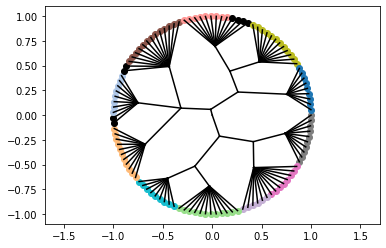

In [70]:
# bundle('karate', .1, 3, True, False, .9, .005, .2, .012)
bundle('football', .1, 3, True, False, .9, .003, .05, .01)
# bundle('caltech', .1, 3, True, False, .9, .002, .005, .002)
# bundle('lfr', .1, 3, True, False, .9, .003, .1, .005)

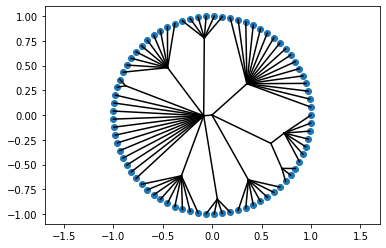

In [51]:
bundle('lesmis', 0.1, 3, True, False, .9, .005, .2, .012)